In [1]:
import ray
import numpy as np
import matplotlib.pyplot as plt
from environment import SimpleEnv
from custom_default_nn import BaselineMLPModel
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.pre_checks.env import check_env
from ray.rllib.algorithms.ppo import PPOConfig

episode: 0
cumulative reward: -10


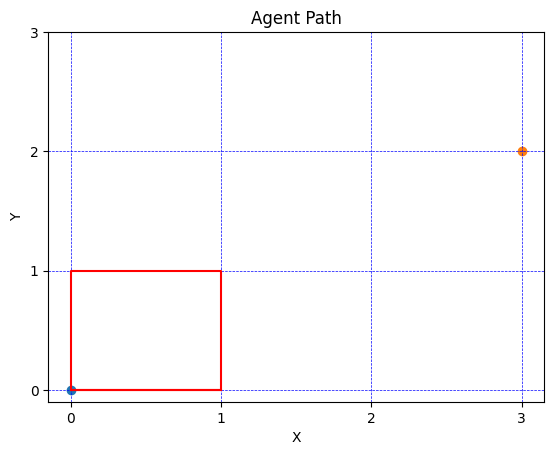

In [2]:
# instantiate the env
length, width, capacity = 4, 4, 2
edge_capacity = np.full((length,width,4),capacity)
nets = [(0,0), (3,2)]
macros = []
env= SimpleEnv(length, width, nets, macros, edge_capacity)
num_episodes = 1

# render the env with random moves
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        total_reward += reward

        if done:
            break

    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [3]:
# register and check the env
register_env("simple_env", lambda config: SimpleEnv(length, width, nets,macros, edge_capacity))

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))
ModelCatalog.register_custom_model("BaselineMLPModel", BaselineMLPModel)

2023-12-15 20:33:06,249	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


checking environment ...
All checks passed. No errors found.


/home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [4]:
# config everything
config = (
    PPOConfig()
    .environment(env = "simple_env")
    .framework(framework="torch")
    .evaluation(
        evaluation_interval=15, 
        evaluation_duration=5,      
        evaluation_num_workers=2,  #0 for Colab
        evaluation_parallel_to_training=True, #False for Colab
        evaluation_config = dict(
            explore=False,
            num_workers=1
        ))
    .rollouts(
    num_rollout_workers=2, #1 for Colab
    num_envs_per_worker=1)
    .training(
        model={
            "custom_model": "BaselineMLPModel",
            "custom_model_config": {  # This is the additional configuration for your model
            "node_features_dim": 2,  # Replace with your actual value
            "edge_features_dim": 1,  # Replace with your actual value
            "action_space_dim": 4,  # Replace with your actual value
            # Add other necessary configurations specific to your model
            }
        }#,
        #_enable_learner_api=False
    )
)
algo = config.build()

2023-12-15 20:33:10,589	INFO worker.py:1538 -- Started a local Ray instance.
(RolloutWorker pid=31955) 2023-12-15 20:33:15,680	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=31955) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=31955)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=31955) 2023-12-15 20:33:15,687	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=31956) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=31956) 

(RolloutWorker pid=31955) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=31955)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=31956) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=31956)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=31955) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=31955)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=31956) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=31956)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=31955) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/

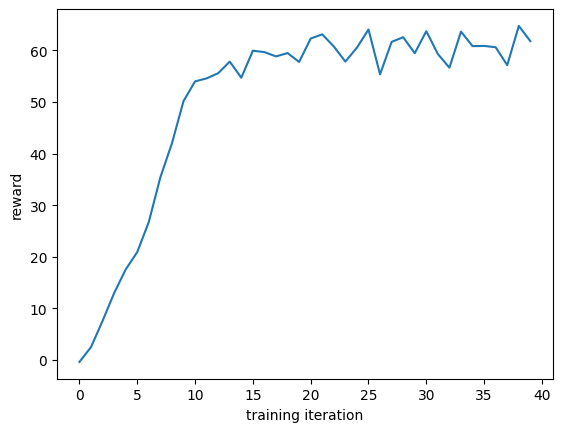

In [5]:
# train the policy for 10 iterations, also plot the mean reward vs iteration 
rewards = []
for i in range (40):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])
plt.plot(rewards)
plt.xlabel("training iteration")
plt.ylabel("reward")
plt.show()

episode: 0
cumulative reward: -10


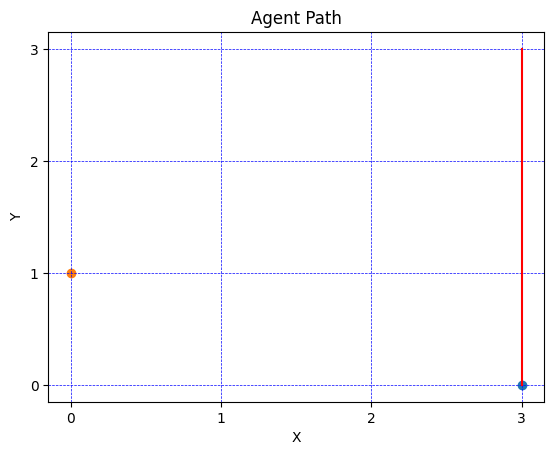

In [26]:
# run inference
num_episodes = 1
env= SimpleEnv(length, width, [(3,0), (0,1)], macros, edge_capacity)
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs, explore=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break
        
    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [7]:
print(algo.get_policy().model)

BaselineMLPModel(
  (policy_nn): BaselineMLP(
    (readout): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): SELU()
      (2): Linear(in_features=2, out_features=2, bias=True)
      (3): SELU()
    )
    (readout_policy): Linear(in_features=2, out_features=4, bias=True)
    (readout_value): Linear(in_features=2, out_features=1, bias=True)
  )
  (value_nn): BaselineMLP(
    (readout): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): SELU()
      (2): Linear(in_features=2, out_features=2, bias=True)
      (3): SELU()
    )
    (readout_policy): Linear(in_features=2, out_features=4, bias=True)
    (readout_value): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [5]:
# release the resources
algo.stop()
ray.shutdown()

NameError: name 'algo' is not defined

In [3]:
np.array((1,2))

array([1, 2])

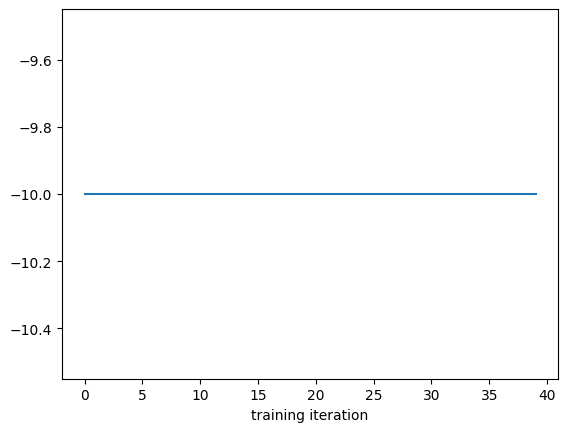

(RolloutWorker pid=35222) 2023-12-15 20:54:40,383	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=35222) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=35222)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=35222) 2023-12-15 20:54:40,401	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=35752) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=35752)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=35752) 20

In [27]:
shit = []
for i in range (40):
    shit.append(-10)
plt.plot(shit)
plt.xlabel("training iteration")
plt.show("reward")
